# Project 5: VehicleDetection

### Goals & Brief Steps of the Project
- Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier.

- Apply a color transform and append binned color features, as well as histograms of color, and combine with HOG features.

- Normalize features and randomize a selection for training and testing.

- Implement a sliding-window technique and use the trained classifier to search for vehicles in images.

- Run the pipeline on a video stream and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.

- Estimate a bounding box for vehicles detected.


### Environment

#### Hardware:
- CPU: i7 - 6700HQ
- GPU: GeForce GTX 960M

#### Software:
- OS: Windows 10 64bit

### Import Required Libraries

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import pickle
import numpy as np
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
import time
import glob
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
from collections import deque
from moviepy.editor import VideoFileClip
from IPython.display import HTML

### Loading the Data

In [2]:
car_images = glob.glob('data/vehicles/*/*.png')
noncar_images = glob.glob('data/non-vehicles/*/*.png')
print('Length of vehicle images: ', len(car_images))
print('Length of non-vehicle images: ', len(car_images))

Length of vehicle images:  8792
Length of non-vehicle images:  8792


### Data Visualization

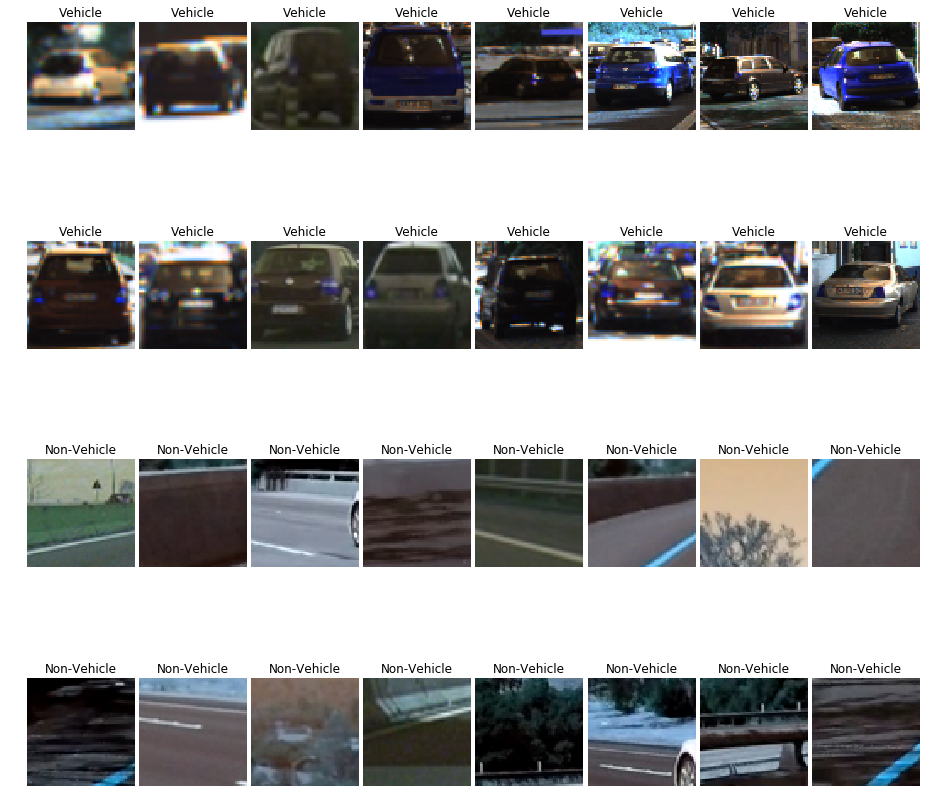

In [3]:
fig, axs = plt.subplots(4, 8, figsize=(16, 16))
fig.subplots_adjust(hspace=.02, wspace=.04)
axs = axs.ravel()

for i in np.arange(16):
    img = cv2.imread(car_images[np.random.randint(0, len(car_images))])
    axs[i].axis('off')
    axs[i].set_title('Vehicle', fontsize = 12)
    axs[i].imshow(img)

for i in np.arange(16, 32):
    img = cv2.imread(noncar_images[np.random.randint(0, len(noncar_images))])
    axs[i].axis('off')
    axs[i].set_title('Non-Vehicle', fontsize = 12)
    axs[i].imshow(img)

- Start with reading all the vehicle and non-vehicle images
- Visualize ranom both vehicle images and non-vehicle images

### Histogram of Oriented Gradients (HOG)

In [5]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys',
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       block_norm= 'L2-Hys',
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

- Function for HOG 
- Try to explore color spaces that give the best result with HOG Function

### Visualization of Hog images

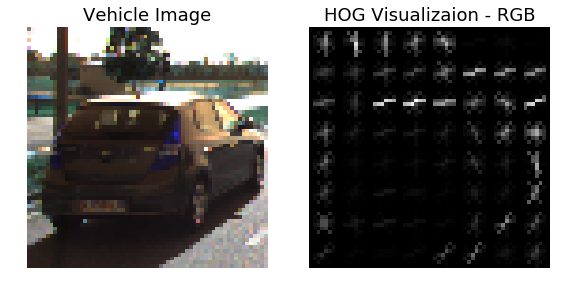

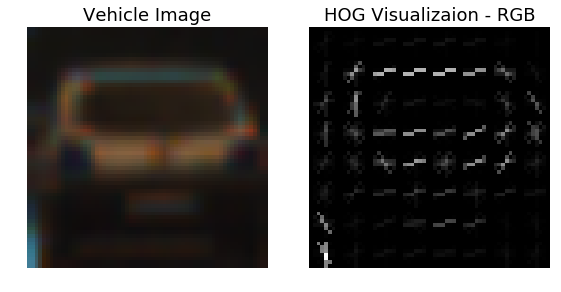

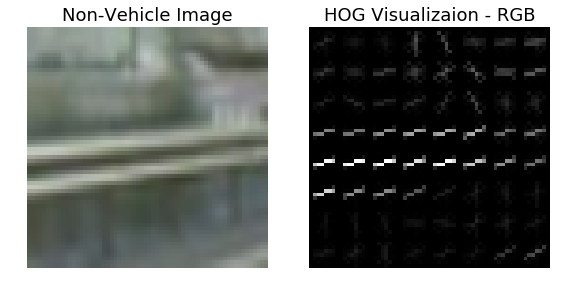

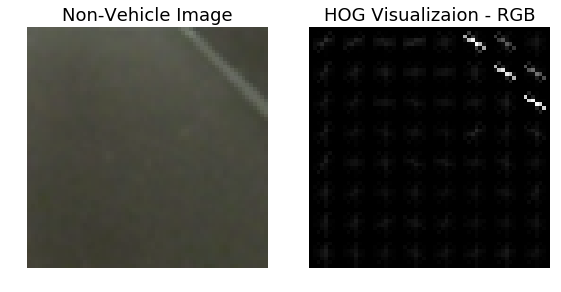

In [6]:
for i in np.arange(2):
    f, (axs1, axs2) = plt.subplots(1, 2, figsize=(8, 8))
    f.tight_layout()
    img = cv2.imread(car_images[np.random.randint(0, len(car_images))])
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Call the function with vis=True
    features, hog_image = get_hog_features(gray, orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=False)
    axs1.axis('off')
    axs1.set_title('Vehicle Image', fontsize = 18)
    axs1.imshow(img)
    axs2.axis('off')
    axs2.set_title('HOG Visualizaion - RGB', fontsize = 18)
    axs2.imshow(hog_image, cmap='gray')

for i in np.arange(2, 4):
    f, (axs1, axs2) = plt.subplots(1, 2, figsize=(8, 8))
    f.tight_layout()
    img = cv2.imread(noncar_images[np.random.randint(0, len(noncar_images))])
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Call the function with vis=True
    features, hog_image = get_hog_features(gray, orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=False)
    axs1.axis('off')
    axs1.set_title('Non-Vehicle Image', fontsize = 18)
    axs1.imshow(img)
    axs2.axis('off')
    axs2.set_title('HOG Visualizaion - RGB', fontsize = 18)
    axs2.imshow(hog_image, cmap='gray')

#### HOG in YUV

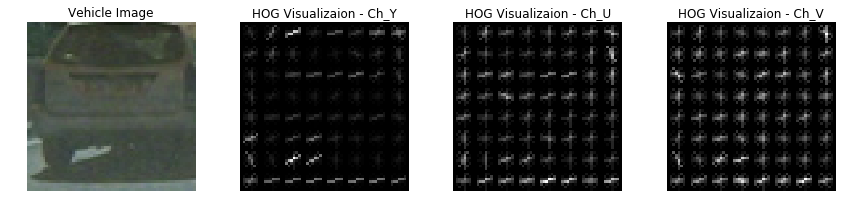

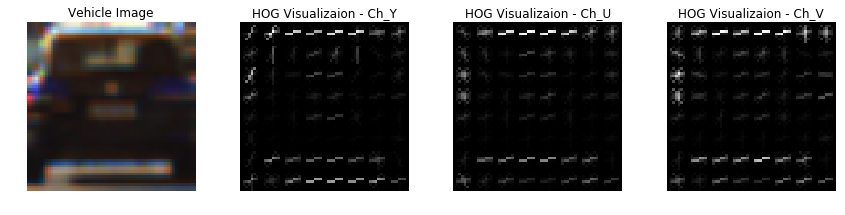

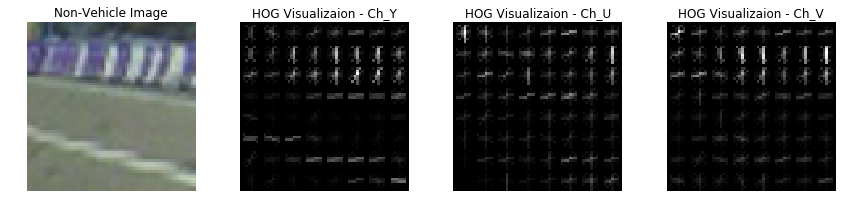

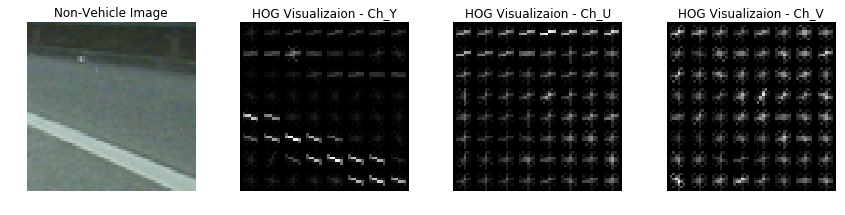

In [9]:
for i in np.arange(2):
    f, (axs1, axs2, axs3, axs4) = plt.subplots(1, 4, figsize=(12, 12))
    f.tight_layout()
    img = cv2.imread(car_images[np.random.randint(0, len(car_images))])
    YUV = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    # Call the function with vis=True
    features, hog_image_0 = get_hog_features(YUV[:,:,0], orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=False)
    features, hog_image_1 = get_hog_features(YUV[:,:,1], orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=False)
    features, hog_image_2 = get_hog_features(YUV[:,:,2], orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=False)
    axs1.axis('off')
    axs1.set_title('Vehicle Image', fontsize = 12)
    axs1.imshow(img)
    axs2.axis('off')
    axs2.set_title('HOG Visualizaion - Ch_Y', fontsize = 12)
    axs2.imshow(hog_image_0, cmap='gray')
    axs3.axis('off')
    axs3.set_title('HOG Visualizaion - Ch_U', fontsize = 12)
    axs3.imshow(hog_image_1, cmap='gray')
    axs4.axis('off')
    axs4.set_title('HOG Visualizaion - Ch_V', fontsize = 12)
    axs4.imshow(hog_image_2, cmap='gray')

for i in np.arange(2):
    f, (axs1, axs2, axs3, axs4) = plt.subplots(1, 4, figsize=(12, 12))
    f.tight_layout()
    img = cv2.imread(noncar_images[np.random.randint(0, len(noncar_images))])
    YUV = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    # Call the function with vis=True
    features, hog_image_0 = get_hog_features(YUV[:,:,0], orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=False)
    features, hog_image_1 = get_hog_features(YUV[:,:,1], orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=False)
    features, hog_image_2 = get_hog_features(YUV[:,:,2], orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=False)
    axs1.axis('off')
    axs1.set_title('Non-Vehicle Image', fontsize = 12)
    axs1.imshow(img)
    axs2.axis('off')
    axs2.set_title('HOG Visualizaion - Ch_Y', fontsize = 12)
    axs2.imshow(hog_image_0, cmap='gray')
    axs3.axis('off')
    axs3.set_title('HOG Visualizaion - Ch_U', fontsize = 12)
    axs3.imshow(hog_image_1, cmap='gray')
    axs4.axis('off')
    axs4.set_title('HOG Visualizaion - Ch_V', fontsize = 12)
    axs4.imshow(hog_image_2, cmap='gray')

#### HOG in YCrCb

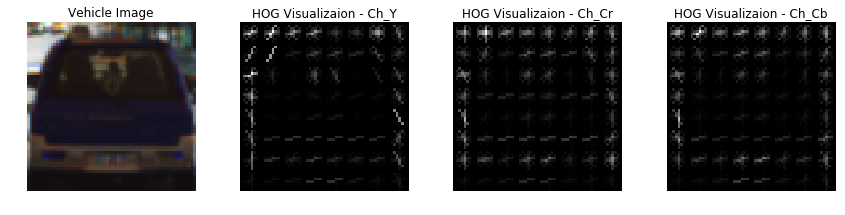

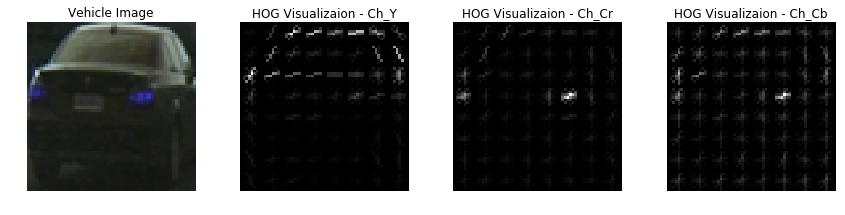

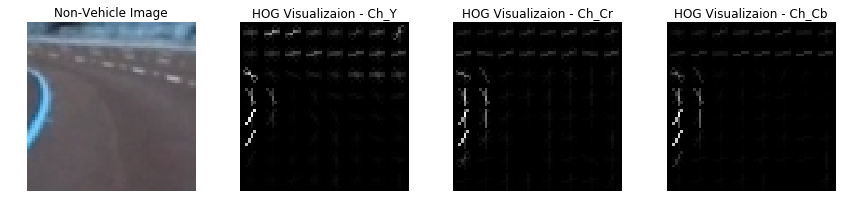

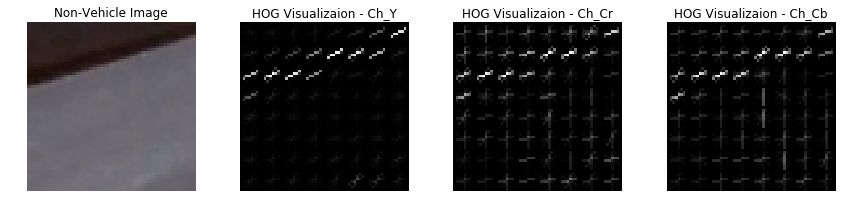

In [10]:
for i in np.arange(2):
    f, (axs1, axs2, axs3, axs4) = plt.subplots(1, 4, figsize=(12, 12))
    f.tight_layout()
    img = cv2.imread(car_images[np.random.randint(0, len(car_images))])
    YCrCb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    # Call the function with vis=True
    features, hog_image_0 = get_hog_features(YCrCb[:,:,0], orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=False)
    features, hog_image_1 = get_hog_features(YCrCb[:,:,1], orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=False)
    features, hog_image_2 = get_hog_features(YCrCb[:,:,2], orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=False)
    axs1.axis('off')
    axs1.set_title('Vehicle Image', fontsize = 12)
    axs1.imshow(img)
    axs2.axis('off')
    axs2.set_title('HOG Visualizaion - Ch_Y', fontsize = 12)
    axs2.imshow(hog_image_0, cmap='gray')
    axs3.axis('off')
    axs3.set_title('HOG Visualizaion - Ch_Cr', fontsize = 12)
    axs3.imshow(hog_image_1, cmap='gray')
    axs4.axis('off')
    axs4.set_title('HOG Visualizaion - Ch_Cb', fontsize = 12)
    axs4.imshow(hog_image_2, cmap='gray')

for i in np.arange(2):
    f, (axs1, axs2, axs3, axs4) = plt.subplots(1, 4, figsize=(12, 12))
    f.tight_layout()
    img = cv2.imread(noncar_images[np.random.randint(0, len(noncar_images))])
    YCrCb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    # Call the function with vis=True
    features, hog_image_0 = get_hog_features(YCrCb[:,:,0], orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=False)
    features, hog_image_1 = get_hog_features(YCrCb[:,:,1], orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=False)
    features, hog_image_2 = get_hog_features(YCrCb[:,:,2], orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=False)
    axs1.axis('off')
    axs1.set_title('Non-Vehicle Image', fontsize = 12)
    axs1.imshow(img)
    axs2.axis('off')
    axs2.set_title('HOG Visualizaion - Ch_Y', fontsize = 12)
    axs2.imshow(hog_image_0, cmap='gray')
    axs3.axis('off')
    axs3.set_title('HOG Visualizaion - Ch_Cr', fontsize = 12)
    axs3.imshow(hog_image_1, cmap='gray')
    axs4.axis('off')
    axs4.set_title('HOG Visualizaion - Ch_Cb', fontsize = 12)
    axs4.imshow(hog_image_2, cmap='gray')

### Training Liniear Classifier to Classify Vehicles and Non-Vehicles & Extracting Features

In [11]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features

In [12]:
# Define a function to compute color histogram features 
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [13]:
# The function for calling bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), orient=9, pix_per_cell=8, cell_per_block=2,
                        hog_channel='ALL', spatial_feat=True, hist_feat=True, hog_feat=True):
    features = []
    # Iteration through the list of images
    for img in imgs:
        img_features = []
        img = cv2.imread(img)
        # Apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            elif cspace == 'LUV':
                feature_img = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
            elif cspace == 'HLS':
                feature_img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
            elif cspace == 'YUV':
                feature_img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
            elif cspace == 'YCrCb':
                feature_img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        else: feature_img = np.copy(img)
       
        if spatial_feat == True:
            # Apply bin_spatial() to get spatial color features
            spatial_features = bin_spatial(feature_img, size=spatial_size)
            # append to image file features
            img_features.append(spatial_features)
        
        if hist_feat == True:
            # Apply color_hist() to get color histogram features
            hist_features = color_hist(feature_img, hist_bins, bins_range)
            # Append the new feature vector to the features list
            img_features.append(hist_features)
            
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_img.shape[2]):
                    hog_features.append(get_hog_features(feature_img[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_img[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            img_features.append(hog_features)
        
        features.append(np.concatenate(img_features))
    # Return list of feature vectors
    return features

#### Extract Features

In [14]:
# Select features to capture
spatial_feature = True # on or off
hist_feature = True
hog_feature = True

# cspace = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
# cspace = 'HSV'
# cspace = 'LUV'
# cspace = 'HLS'
# cspace = 'YUV'
cspace = 'YCrCb'

orient = 9
pix_per_cell = 8
cell_per_block = 2
hist_range=(0, 256)
bins_range=(0, 256)
# hog_channel = 0 # Can be 0, 1, 2, or "ALL"
# hog_channel = 1
# hog_channel = 2
hog_channel = "ALL"
spatial_size = (32, 32)
hist_bins = 32

cars = []
non_cars=[]
cars.extend(car_images)
non_cars.extend(noncar_images)

# Define number of random samples to train classifier on and get their indexes
n_random_samples = 1000
random_indexes = np.random.randint(0,len(cars),n_random_samples)

random_indexes = np.random.randint(0,len(non_cars),n_random_samples)

# Extract the random cars and non-cars images
random_cars = cars#np.array(cars)[random_indexes]
random_non_cars = non_cars#np.array(non_cars)[random_indexes]

# t1 = time.time()
car_features = extract_features(cars, cspace, spatial_size,
                        hist_bins,  hist_range, orient, pix_per_cell, cell_per_block,
                        hog_channel, spatial_feature, hist_feature, hog_feature)

noncar_features = extract_features(non_cars, cspace, spatial_size,
                        hist_bins,  hist_range, orient, pix_per_cell, cell_per_block,
                        hog_channel, spatial_feature, hist_feature, hog_feature)
# t2 = time.time()
# print(round(t2-t1, 2), 'Seconds to extract HOG featues')

# Create an array stack of feature vectors
X = np.vstack((car_features, noncar_features)).astype(np.float64)



# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=rand_state)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)

# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block') 

#The number of features in your final feature vector will be 
#the total number of block positions multiplied by the number of cells per block, 
#times the number of orientations, or in the case shown above: 7\times7\times2\times2\times9 = 17647×7×2×2×9=1764. 
print('Feature vector length:', len(X_train[0]))

# USe a linear SVC
svc = LinearSVC()

# Check the training time for the SVC
t1 = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t1, 2), 'Seconds to train SCV')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t1 = time.time()
n_predict = 10
print('SVC redicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t1, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
11.03 Seconds to train SCV
Test Accuracy of SVC =  0.9901
SVC redicts:  [ 0.  1.  0.  0.  0.  0.  1.  0.  1.  0.]
For these 10 labels:  [ 0.  1.  0.  0.  0.  0.  1.  0.  1.  0.]
0.01604 Seconds to predict 10 labels with SVC


- Table 1

| Conf. Label | Cspace | Orient | PPC | CPB | HOG CH | Extract Time(s) | Classifier | Accuracy(%) | Train TIme(s) |
| :---------: | :----: | :----: | :-: | :-: | :----: | :-------------: | :--------: | :---------: | :-----------: | 
| 1           | RGB    | 9      | 8   | 2   | 0      | 98.56           | SVC        | 93.24       | 32.84         |  
| 2           | HSV    | 9      | 8   | 2   | 0      | 69.51           | SVC        | 91.36       | 16.33         | 
| 3           | LUV    | 9      | 8   | 2   | 0      | 62.77           | SVC        | 92.03       | 27.2          | 
| 4           | HLS    | 9      | 8   | 2   | 0      | 62.24           | SVC        | 91.78       | 16.23         | 
| 5           | YUV    | 9      | 8   | 2   | 0      | 66.72           | SVC        | 92.85       | 31.3          | 
| 6           | YCrCb  | 9      | 8   | 2   | 0      | 62.34           | SVC        | 93.41       | 32.29         | 
| 7           | RGB    | 9      | 8   | 2   | 1      | 59.67           | SVC        | 92.45       | 28.34         | 
| 8           | HSV    | 9      | 8   | 2   | 1      | 56.83           | SVC        | 90.06       | 3.8           | 
| 9           | LUV    | 9      | 8   | 2   | 1      | 52.78           | SVC        | 94.31       | 12.64         | 
| 10          | HLS    | 9      | 8   | 2   | 1      | 46.87           | SVC        | 92.6        | 27.52         | 
| 11          | YUV    | 9      | 8   | 2   | 1      | 46.87           | SVC        | 90.4        | 23.35         | 
| 12          | YCrCb  | 9      | 8   | 2   | 1      | 60.7            | SVC        | 93.69       | 15.29         | 
| 13          | RGB    | 9      | 8   | 2   | 2      | 40.81           | SVC        | 91.39       | 30.3          |  
| 14          | HSV    | 9      | 8   | 2   | 2      | 46.44           | SVC        | 92.57       | 24.55         | 
| 15          | LUV    | 9      | 8   | 2   | 2      | 50.79           | SVC        | 90.4        | 24.67         | 
| 16          | HLS    | 9      | 8   | 2   | 2      | 40.76           | SVC        | 90.03       | 6.74          | 
| 17          | YUV    | 9      | 8   | 2   | 2      | 50.41           | SVC        | 94.43       | 16.31         | 
| 18          | YCrCb  | 9      | 8   | 2   | 2      | 41.99           | SVC        | 91.08       | 26.49         | 
| 19          | RGB    | 9      | 8   | 2   | ALL    | 121.57          | SVC        | 95.07       | 63.76         | 
| 20          | HSV    | 9      | 8   | 2   | ALL    | 148.7           | SVC        | 96.96       | 39.66         | 
| 21          | LUV    | 9      | 8   | 2   | ALL    | 117.17          | SVC        | 96.59       | 26.77         | 
| 22          | HLS    | 9      | 8   | 2   | ALL    | 114.81          | SVC        | 97.47       | 39.07         | 
| 23          | YUV    | 9      | 8   | 2   | ALL    | 112.16          | SVC        | 96.85       | 21.88         | 
| 24          | YCrCb  | 9      | 8   | 2   | ALL    | 134.14          | SVC        | 96.71       | 23.79         | 

- Table 2

| Parameters     | Values   |
| :------------: | :------: | 
| Color Space    | YCrCb    |   
| Orient         | 8        | 
| pix_per_cell   | (8, 8)   |
| cell_per_block | (2, 2)   |
| spatial_size	 | (32, 32) | 
| hist_bins	     | 32       | 
| HOG COLOR CH   | 'ALL'    |

- Tried various combinations of parameters and color spaces to get the better accuracy
- Generally color space of YCrCb and YUV give the better accuracy
- Using All three channle of HOG gives the best result
- Trained a linear SVM using HOG features from all color spaces, and the color histogram features.
- With all of the best parameters in Table 1, the accuracy is 99.01%

### Sliding Window Search

In [16]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

In [17]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    x_span = x_start_stop[1] - x_start_stop[0]
    y_span = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    x_pixels_step = np.int(xy_window[0]*(1-xy_overlap[0]))
    y_pixels_step = np.int(xy_window[1]*(1-xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((x_span-nx_buffer)/x_pixels_step)
    ny_windows = np.int((y_span-ny_buffer)/y_pixels_step)
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    #     Note: you could vectorize this step, but in practice
    #     you'll be considering windows one by one with your
    #     classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*x_pixels_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*y_pixels_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))

        # Calculate each window position
        # Append window position to list
    # Return the list of windows
    return window_list

In [18]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, cspace='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, cspace=cspace, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [19]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

- Now that the classifier is trained, and is known to perform pretty well on the test set. In order detect cars from an image, a sliding window with overlaps can be implemented and features can be extracted for each of them.

### Testing the Classifier

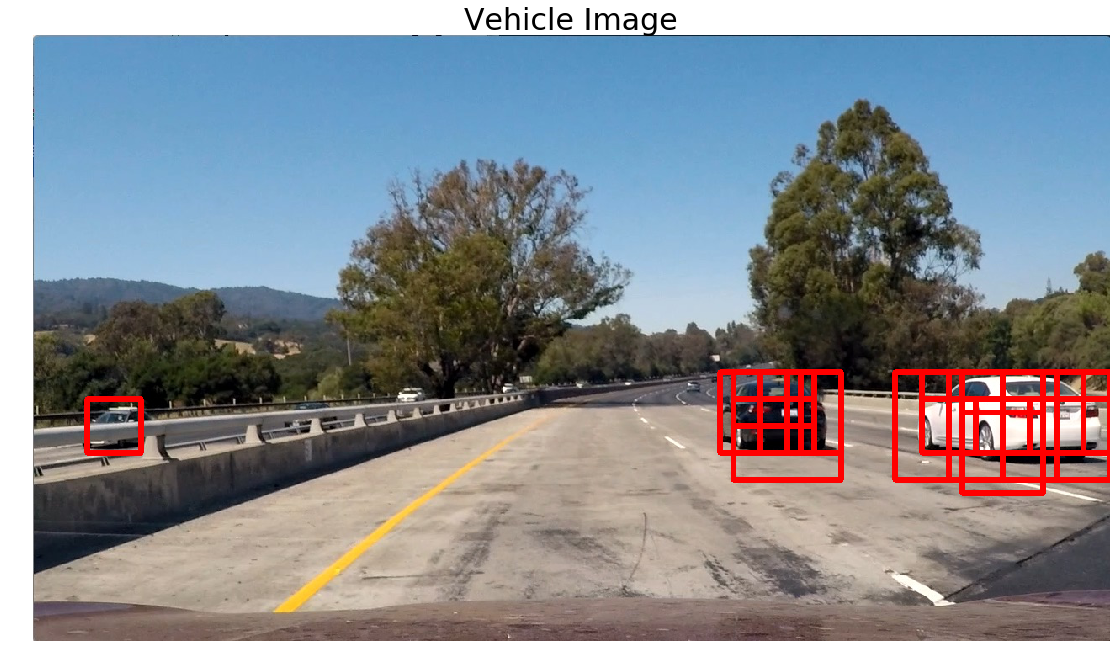

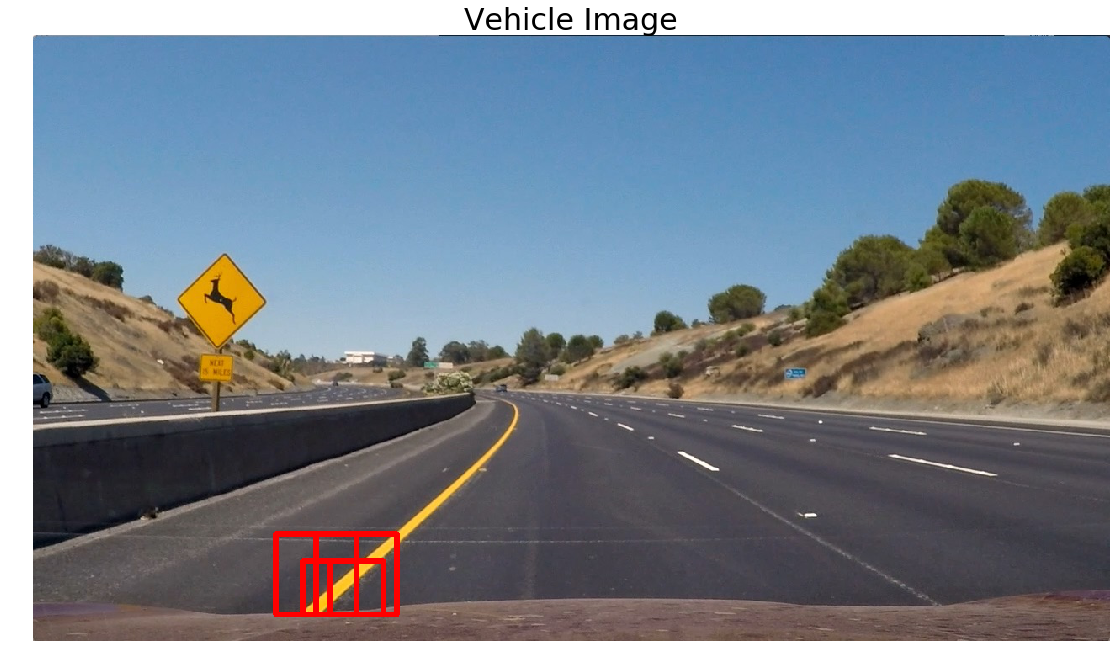

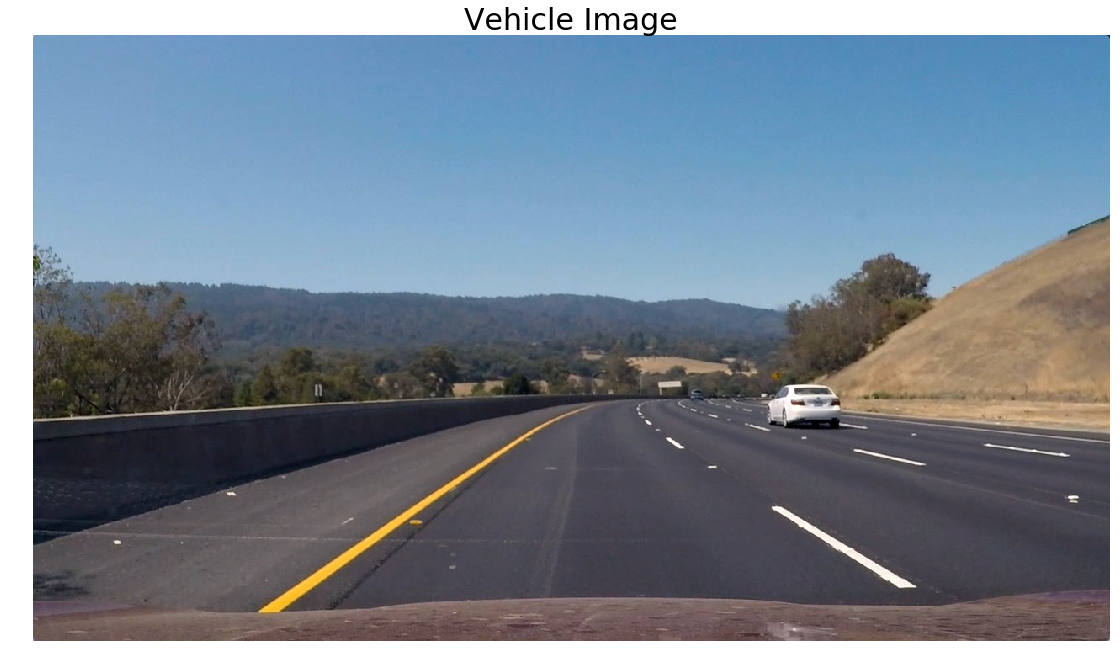

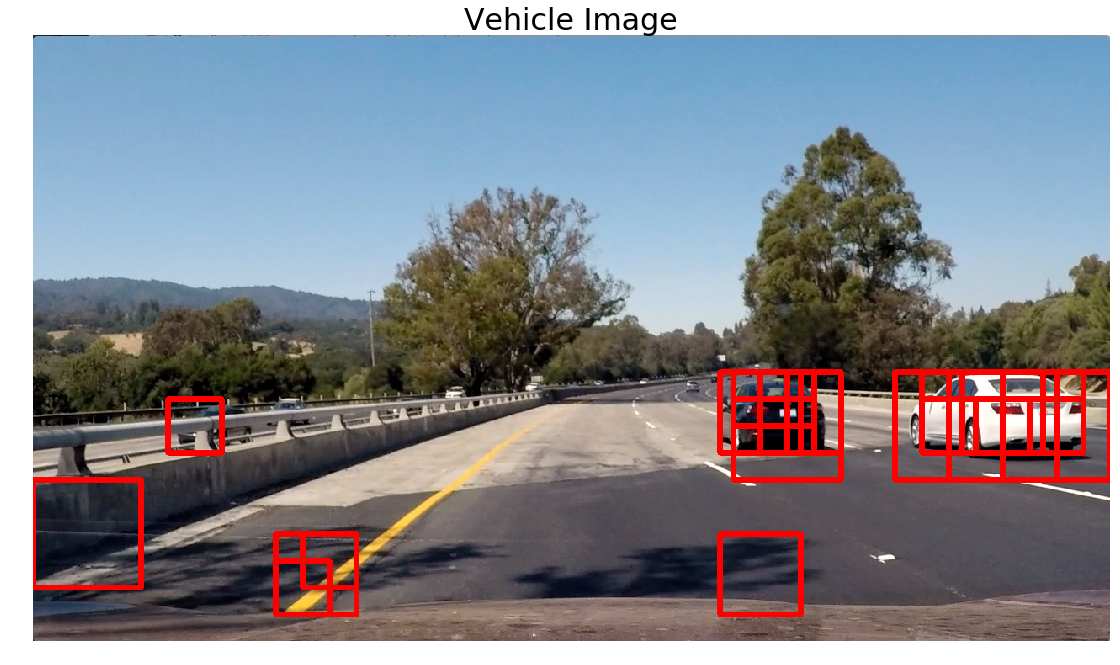

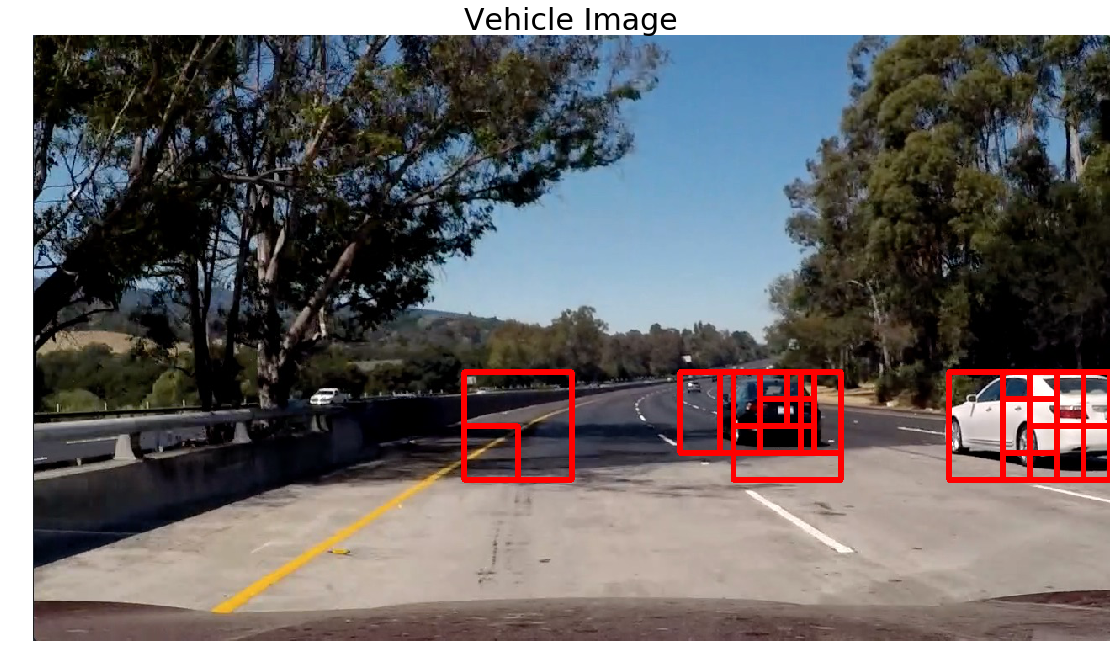

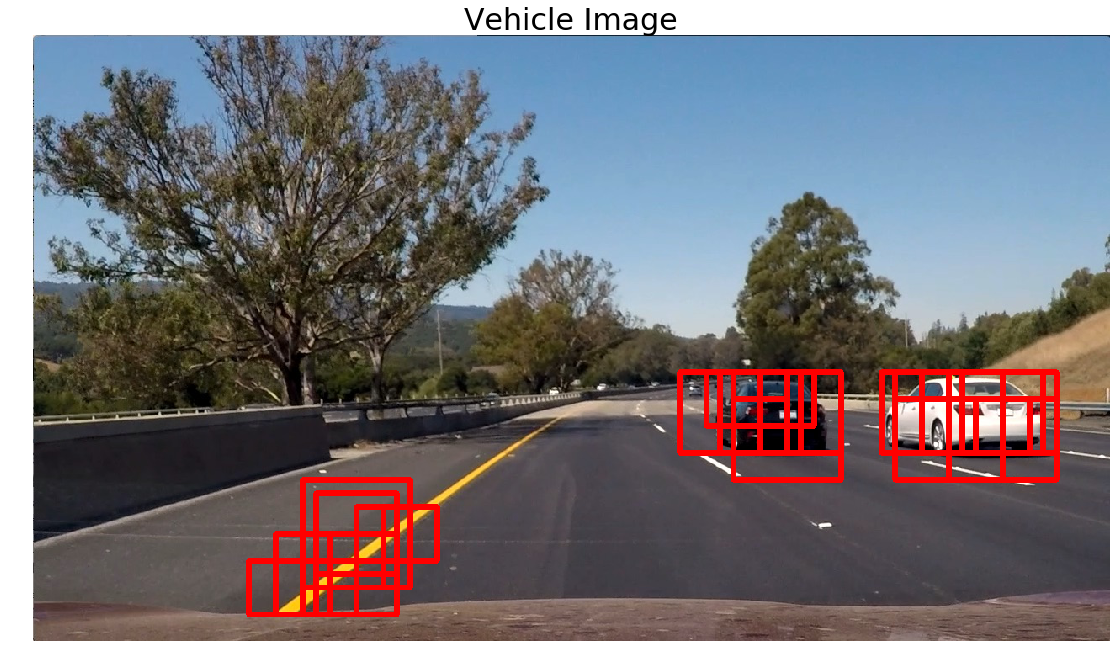

In [20]:
test_imgs = glob.glob('./test_images/*.jpg')

# Select features to capture
spatial_feature = True
hist_feature = True
hog_feature = True

# Define feature parameters
# cspace = 'YCrCb' # Options: RGB, HSV, LUV, HLS, YUV, YCrCb
cspace = 'YUV'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_size = (32, 32)
hist_bins = 32

# define window parameters
y_start_stop = [400,700]
overlap = 0.5
xy_window1 = (64,64)
xy_window2 = (96,96)
xy_window3 = (128,128)


for i, img in enumerate(test_imgs):
    t1=time.time()
    f, axs = plt.subplots(1, 1, figsize=(24, 9))
    img = cv2.imread(img)
    draw_image = np.copy(img)
#     img = img.astype(np.float32)/255
    
    #windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
    #               xy_window=(64, 96), xy_overlap=(overlap, overlap))
    
    windows1 = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                   xy_window=xy_window1, xy_overlap=(overlap, overlap))
    
    
    windows2 = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                   xy_window=xy_window2, xy_overlap=(overlap, overlap))
    
    
    windows3 = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                   xy_window=xy_window3, xy_overlap=(overlap, overlap))
    
    hot_windows1 = search_windows(img, windows1, svc, X_scaler, cspace=cspace, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feature, 
                        hist_feat=hist_feature, hog_feat=hog_feature)                       

    hot_windows2 = search_windows(img, windows2, svc, X_scaler, cspace=cspace, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feature, 
                        hist_feat=hist_feature, hog_feat=hog_feature)                       
    
    hot_windows3 = search_windows(img, windows3, svc, X_scaler, cspace=cspace, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feature, 
                        hist_feat=hist_feature, hog_feat=hog_feature)                       


    window_img = draw_boxes(draw_image, hot_windows1, color=(0, 0, 255), thick=6)                    
    window_img = draw_boxes(window_img, hot_windows2, color=(0, 0, 255), thick=6)
    window_img = draw_boxes(window_img, hot_windows3, color=(0, 0, 255), thick=6)
    f.tight_layout()
    axs.axis('off')
    axs.set_title('Vehicle Image', fontsize=30)
    axs.imshow(cv2.cvtColor(window_img, cv2.COLOR_BGR2RGB))

- For the searching the images for vehicles, extract the hog features of the image and then sub-sample that image into smaller images. And then use the trained classifier to find vehicles on the images. 

- Searching on three scales using YCrCb three-channel HOG features, spatially binned color, and histograms of color in the feature vector, which provide a nice result.

### Hog Sub-Sample Method

In [21]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
              cell_per_block, spatial_size, hist_bins, cspace = 'RGB', hog_channel='ALL', spatial_feat=True, hist_feat=True):
    # Array of rectangles where cars were detected
    rect = []
    
    draw_img = np.copy(img)
#     img = img.astype(np.float32)//255
    
    # Initialize a heatmap with zeros
    heatmap = np.zeros_like(img[:,:,0])
    
    img_tosearch = img[ystart:ystop,:,:]
    # Apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_BGR2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_BGR2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_BGR2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_BGR2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_BGR2YCrCb)
    else: ctrans_tosearch = np.copy(img_tosearch)
        
#     ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # Select color space for HOG
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else:
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1 # total number of block positions in X axis
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 # total number of block positions in Y axis 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
#     nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    if hog_channel =='ALL':
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    else:
        hog1 = get_hog_features(ctrans_tosearch[:,:,hog_channel], orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            
            if hog_channel == 'ALL':
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch:
            if ((spatial_feat == True) or (hist_feat == True)):
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
                if spatial_feat == True and hist_feat == True:
                    spatial_features = bin_spatial(subimg, size=spatial_size)
                    hist_features = color_hist(subimg, nbins=hist_bins)
#                     X = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1).astype(np.float64)
                    X = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
                    
                elif hist_feat == True: 
                    hist_features = color_hist(subimg, nbins=hist_bins)
#                     X = np.hstack((hist_features, hog_features)).reshape(1, -1).astype(np.float64)
                    X = np.hstack((hist_features, hog_features)).reshape(1, -1)
                else:
                    spatial_features = bin_spatial(subimg, size=spatial_size)
#                     X = np.hstack((spatial_features, hog_features)).reshape(1, -1).astype(np.float64)
                    X = np.hstack((spatial_features, hog_features)).reshape(1, -1)
            else: 
                #print("test")
                X  = hog_features.reshape(1, -1)
                    
#             spatial_features = bin_spatial(subimg, size=spatial_size)
#             hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
#             test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            test_features = X_scaler.transform(X) 
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
#             print(test_predction)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
#                 rect.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1
    return draw_img, heatmap
#     return draw_img
#     return rect

In [22]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars_1(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
              cell_per_block, spatial_size, hist_bins, cspace = 'RGB', hog_channel='ALL', spatial_feat=True, hist_feat=True):
    # Array of rectangles where cars were detected
    rect = []
    
    draw_img = np.copy(img)
#     img = img.astype(np.float32)//255
    
    # Initialize a heatmap with zeros
    heatmap = np.zeros_like(img[:,:,0])
    
    img_tosearch = img[ystart:ystop,:,:]
    # Apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_BGR2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_BGR2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_BGR2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_BGR2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_BGR2YCrCb)
    else: ctrans_tosearch = np.copy(img_tosearch)
        
#     ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # Select color space for HOG
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else:
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1 # total number of block positions in X axis
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 # total number of block positions in Y axis 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
#     nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    if hog_channel =='ALL':
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    else:
        hog1 = get_hog_features(ctrans_tosearch[:,:,hog_channel], orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            
            if hog_channel == 'ALL':
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch:
            if ((spatial_feat == True) or (hist_feat == True)):
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
                if spatial_feat == True and hist_feat == True:
                    spatial_features = bin_spatial(subimg, size=spatial_size)
                    hist_features = color_hist(subimg, nbins=hist_bins)
#                     X = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1).astype(np.float64)
                    X = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
                    
                elif hist_feat == True: 
                    hist_features = color_hist(subimg, nbins=hist_bins)
#                     X = np.hstack((hist_features, hog_features)).reshape(1, -1).astype(np.float64)
                    X = np.hstack((hist_features, hog_features)).reshape(1, -1)
                else:
                    spatial_features = bin_spatial(subimg, size=spatial_size)
#                     X = np.hstack((spatial_features, hog_features)).reshape(1, -1).astype(np.float64)
                    X = np.hstack((spatial_features, hog_features)).reshape(1, -1)
            else: 
                #print("test")
                X  = hog_features.reshape(1, -1)
                    
#             spatial_features = bin_spatial(subimg, size=spatial_size)
#             hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
#             test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            test_features = X_scaler.transform(X) 
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
#             print(test_predction)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
#                 cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                rect.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    
#                 heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1
    return rect
#     return draw_img
#     return rect

Test for Finding Cars in Images

In [23]:
test_img = cv2.imread('./test_images/test1.jpg')
ystart = 400
ystop = 650
scale = 1.5
cspace = 'YCrCb'
# cspace = 'YUV'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_size = (32, 32)
hist_bins = 32
# test_img = mpimg.imread('./test_images/test1.jpg')
spatial_feat = True # Spatial features on or off
hist_feat = True

rect = find_cars_1(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, cspace, hog_channel, spatial_feat, hist_feat)

print(len(rect), 'rectangles found in image')

18 rectangles found in image


### Drawing Rectangles on the Images

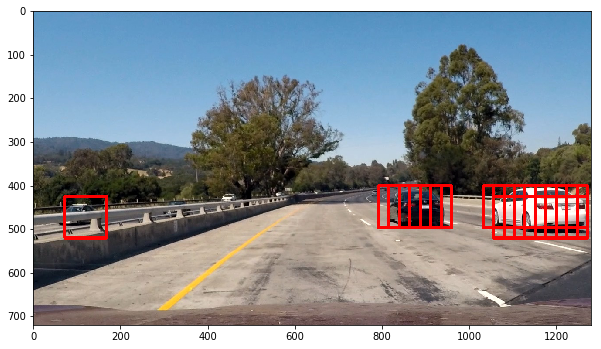

In [25]:
test_img_rect = draw_boxes(test_img, rect)
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(test_img_rect, cv2.COLOR_BGR2RGB))

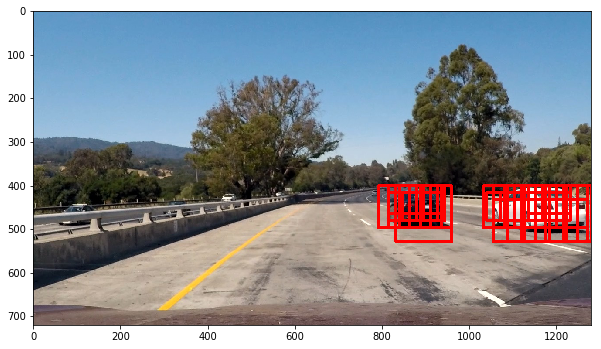

In [26]:
test_img = cv2.imread('./test_images/test1.jpg')

rect = []

cspace = 'YCrCb'
# cspace = 'YUV'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_size = (32, 32)
hist_bins = 32
# test_img = mpimg.imread('./test_images/test1.jpg')
spatial_feat = True # Spatial features on or off
hist_feat = True


ystart = 400
ystop = 464
scale = 1.0
rect.append(find_cars_1(test_img, ystart, ystop, scale, svc, X_scaler, orient, 
                   pix_per_cell, cell_per_block, spatial_size, hist_bins, 
                   cspace, hog_channel, spatial_feat, hist_feat))

ystart = 416
ystop = 480
scale = 1.0
rect.append(find_cars_1(test_img, ystart, ystop, scale, svc, X_scaler, orient, 
                   pix_per_cell, cell_per_block, spatial_size, hist_bins, 
                   cspace, hog_channel, spatial_feat, hist_feat))
ystart = 400
ystop = 496
scale = 1.5
rect.append(find_cars_1(test_img, ystart, ystop, scale, svc, X_scaler, orient, 
                   pix_per_cell, cell_per_block, spatial_size, hist_bins, 
                   cspace, hog_channel, spatial_feat, hist_feat))
ystart = 432
ystop = 528
scale = 1.5
rect.append(find_cars_1(test_img, ystart, ystop, scale, svc, X_scaler, orient, 
                   pix_per_cell, cell_per_block, spatial_size, hist_bins, 
                   cspace, hog_channel, spatial_feat, hist_feat))
ystart = 400
ystop = 528
scale = 2.0
rect.append(find_cars_1(test_img, ystart, ystop, scale, svc, X_scaler, orient, 
                   pix_per_cell, cell_per_block, spatial_size, hist_bins, 
                   cspace, hog_channel, spatial_feat, hist_feat))
ystart = 432
ystop = 560
scale = 2.0
rect.append(find_cars_1(test_img, ystart, ystop, scale, svc, X_scaler, orient, 
                   pix_per_cell, cell_per_block, spatial_size, hist_bins, 
                   cspace, hog_channel, spatial_feat, hist_feat))
ystart = 400
ystop = 596
scale = 3.5
rect.append(find_cars_1(test_img, ystart, ystop, scale, svc, X_scaler, orient, 
                   pix_per_cell, cell_per_block, spatial_size, hist_bins, 
                   cspace, hog_channel, spatial_feat, hist_feat))
ystart = 410
ystop = 660
scale = 3.5
rect.append(find_cars_1(test_img, ystart, ystop, scale, svc, X_scaler, orient, 
                   pix_per_cell, cell_per_block, spatial_size, hist_bins, 
                   cspace, hog_channel, spatial_feat, hist_feat))

# apparently this is the best way to flatten a list of lists
rect = [item for sublist in rect for item in sublist] 
test_img_rects = draw_boxes(test_img, rect)
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(test_img_rects, cv2.COLOR_BGR2RGB))

- Using multiple values of scales parameters and unifiying these gives the better result

In [27]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    bboxes = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bboxes.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img, bboxes

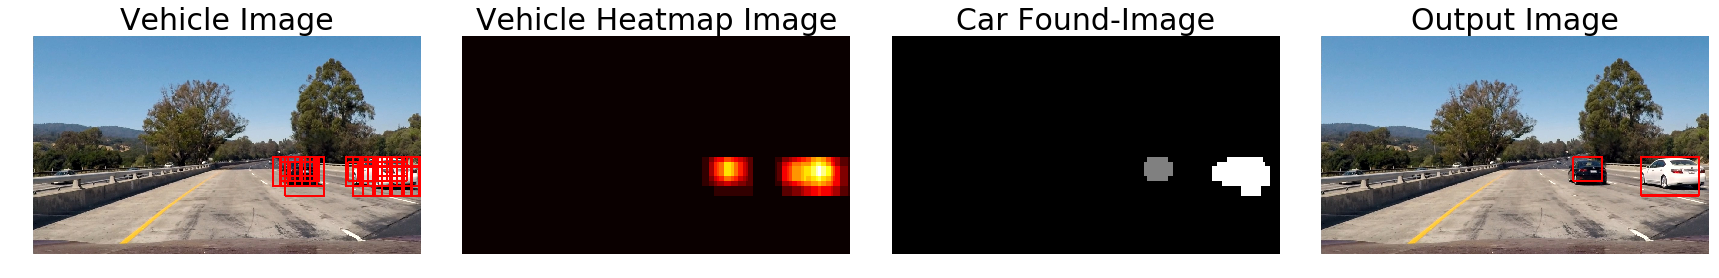

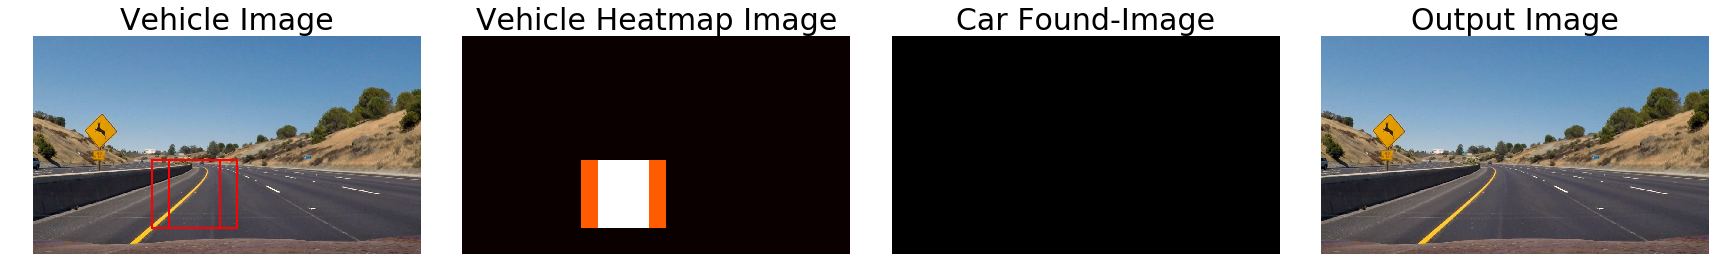

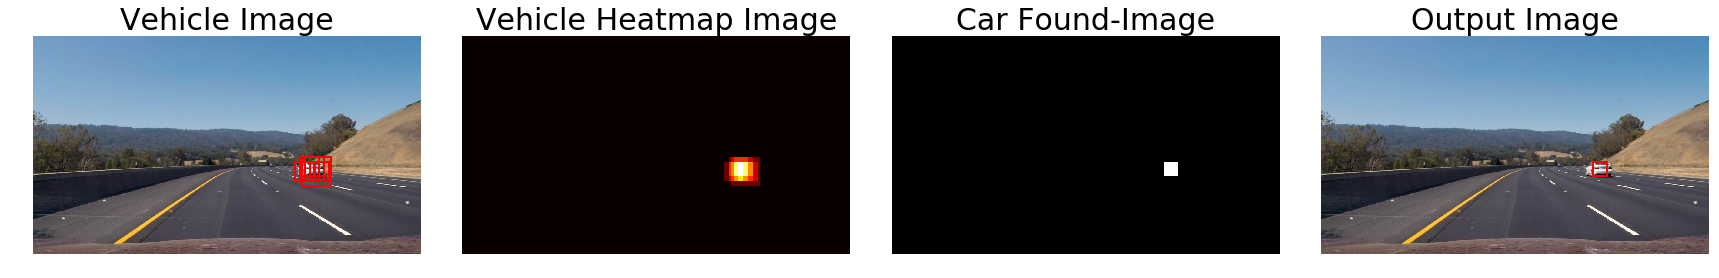

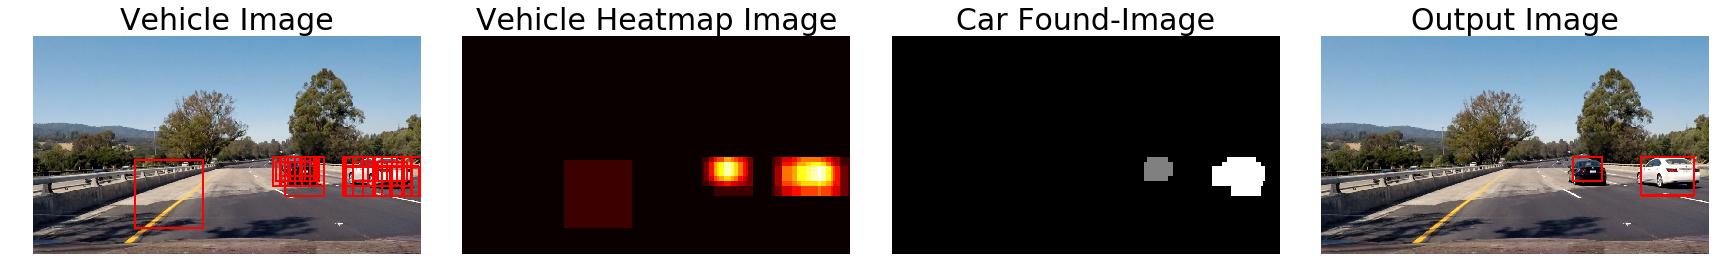

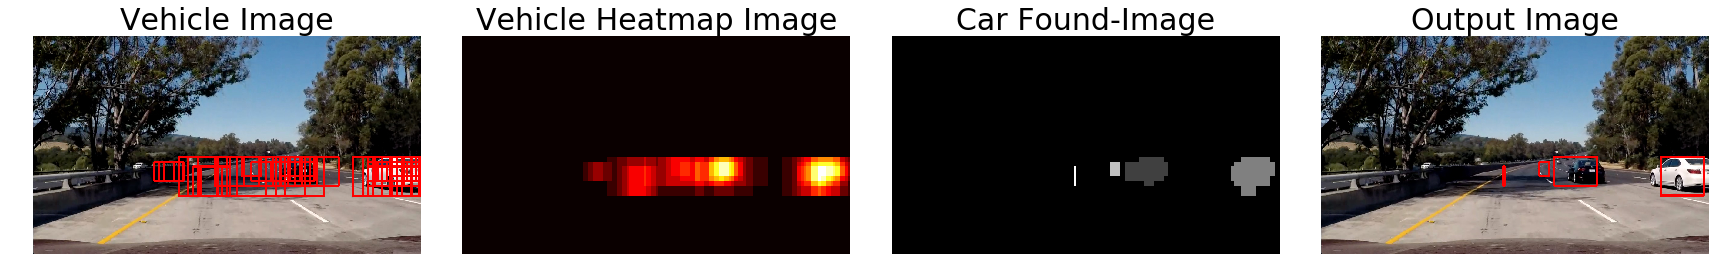

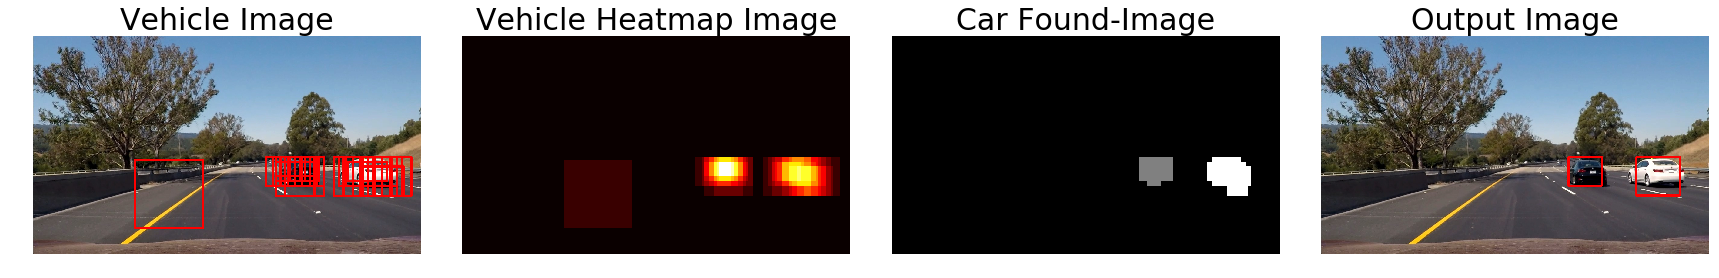

In [30]:
test_imgs = glob.glob('./test_images/*.jpg')


for i, img in enumerate(test_imgs):
    f, (axs1, axs2, axs3, axs4) = plt.subplots(1, 4, figsize=(24, 9))
    test_img = cv2.imread(img)
    
    rect = []

    cspace = 'YCrCb'
#     cspace = 'YUV'
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = 'ALL'
    spatial_size = (32, 32)
    hist_bins = 32
    # test_img = mpimg.imread('./test_images/test1.jpg')
    spatial_feat = True # Spatial features on or off
    hist_feat = True


    ystart = 400
    ystop = 464
    scale = 1.0
    rect.append(find_cars_1(test_img, ystart, ystop, scale, svc, X_scaler, orient, 
                       pix_per_cell, cell_per_block, spatial_size, hist_bins, 
                       cspace, hog_channel, spatial_feat, hist_feat))

    ystart = 416
    ystop = 480
    scale = 1.0
    rect.append(find_cars_1(test_img, ystart, ystop, scale, svc, X_scaler, orient, 
                       pix_per_cell, cell_per_block, spatial_size, hist_bins, 
                       cspace, hog_channel, spatial_feat, hist_feat))
    ystart = 400
    ystop = 496
    scale = 1.5
    rect.append(find_cars_1(test_img, ystart, ystop, scale, svc, X_scaler, orient, 
                       pix_per_cell, cell_per_block, spatial_size, hist_bins, 
                       cspace, hog_channel, spatial_feat, hist_feat))
    ystart = 432
    ystop = 528
    scale = 1.5
    rect.append(find_cars_1(test_img, ystart, ystop, scale, svc, X_scaler, orient, 
                       pix_per_cell, cell_per_block, spatial_size, hist_bins, 
                       cspace, hog_channel, spatial_feat, hist_feat))
    ystart = 400
    ystop = 528
    scale = 2.0
    rect.append(find_cars_1(test_img, ystart, ystop, scale, svc, X_scaler, orient, 
                       pix_per_cell, cell_per_block, spatial_size, hist_bins, 
                       cspace, hog_channel, spatial_feat, hist_feat))
    ystart = 432
    ystop = 560
    scale = 2.0
    rect.append(find_cars_1(test_img, ystart, ystop, scale, svc, X_scaler, orient, 
                       pix_per_cell, cell_per_block, spatial_size, hist_bins, 
                       cspace, hog_channel, spatial_feat, hist_feat))
    ystart = 400
    ystop = 596
    scale = 3.5
    rect.append(find_cars_1(test_img, ystart, ystop, scale, svc, X_scaler, orient, 
                       pix_per_cell, cell_per_block, spatial_size, hist_bins, 
                       cspace, hog_channel, spatial_feat, hist_feat))
    ystart = 410
    ystop = 660
    scale = 3.5
    rect.append(find_cars_1(test_img, ystart, ystop, scale, svc, X_scaler, orient, 
                       pix_per_cell, cell_per_block, spatial_size, hist_bins, 
                       cspace, hog_channel, spatial_feat, hist_feat))

    # apparently this is the best way to flatten a list of lists
    rect = [item for sublist in rect for item in sublist] 
    test_img_rects = draw_boxes(test_img, rect)
    f.tight_layout()
    axs1.axis('off')
    axs1.set_title('Vehicle Image', fontsize=30)
    axs1.imshow(cv2.cvtColor(test_img_rects, cv2.COLOR_BGR2RGB))
    
    axs2.axis('off')
    axs2.set_title('Vehicle Heatmap Image', fontsize=30)
    heatmap_img = np.zeros_like(test_img[:,:,0])
    heatmap_img = add_heat(heatmap_img, rect)
    axs2.imshow(heatmap_img, cmap='hot')
    
    axs3.axis('off')
    axs3.set_title('Car Found-Image', fontsize=30)
    heatmap_img = apply_threshold(heatmap_img, 5.5)
    labels = label(heatmap_img)
    axs3.imshow(labels[0], cmap='gray')
    
    axs4.axis('off')
    axs4.set_title('Output Image', fontsize=30)
    draw_img, rect = draw_labeled_bboxes(np.copy(test_img), labels)
    axs4.imshow(cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB))
#     f.tight_layout()

- Mostly true positives are accompanied by several positive detections, while false positives are usually accompanied by one one or two detections. 
- Threshold is applied to the heatmap
- set all pixels that do no exceed the threshold to zero
- Differenciating the combining heatmap and threshold apply is able to get rid of most false positives. The results for each image is in third

### Video Implementation

In [31]:
# Class to track the vehicles so that if there is only one box around, 
# then it can still detect it without any other false positives
# this is similar to the previous project class to track lines

class Tracker():
    def __init__(self, n=10):
        # number of frames for which to store bbox data
        self.nFrames = n
        # hot windows of the last n frames
        self.recentBoxes = deque([], maxlen=n)
        # current boxes
        self.currentBoxes = None
        
        self.allBoxes = []

    def addBoxes(self):
        self.recentBoxes.appendleft(self.currentBoxes)
            
    def setCurrentBoxes(self, boxes):
        self.currentBoxes = boxes
        
    def getAllBoxes(self):        
        allBoxes = []
        for boxes in self.recentBoxes:
            allBoxes += boxes
        if len(allBoxes)==0:
            self.allBoxes = None
        else:
            self.allBoxes = allBoxes
            
    def update(self, boxes):
        self.setCurrentBoxes(boxes)
        self.addBoxes()
        self.getAllBoxes()

In [40]:
# new processing function that would track the objects 
tracker = Tracker(30)

cspace = 'YCrCb'
# cspace = 'YUV'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_size = (32, 32)
hist_bins = 32
spatial_feat = True # Spatial features on or off
hist_feat = True

def trackFrame(raw_img):

    rect = []

#     cspace = 'YCrCb'
#     orient = 9
#     pix_per_cell = 8
#     cell_per_block = 2
#     hog_channel = 'ALL'
#     spatial_size = (32, 32)
#     hist_bins = 32
#     spatial_feat = True # Spatial features on or off
#     hist_feat = True


    ystart = 400
    ystop = 450
    scale = 1.0
    rect.append(find_cars_1(raw_img, ystart, ystop, scale, svc, X_scaler, orient, 
                       pix_per_cell, cell_per_block, spatial_size, hist_bins, 
                       cspace, hog_channel, spatial_feat, hist_feat))

    
    
    ystart = 420
    ystop = 470
    scale = 1.0
    rect.append(find_cars_1(raw_img, ystart, ystop, scale, svc, X_scaler, orient, 
                       pix_per_cell, cell_per_block, spatial_size, hist_bins, 
                       cspace, hog_channel, spatial_feat, hist_feat))
    ystart = 400
    ystop = 500
    scale = 1.5
    rect.append(find_cars_1(raw_img, ystart, ystop, scale, svc, X_scaler, orient, 
                       pix_per_cell, cell_per_block, spatial_size, hist_bins, 
                       cspace, hog_channel, spatial_feat, hist_feat))
    ystart = 500
    ystop = 600
    scale = 1.5
    rect.append(find_cars_1(raw_img, ystart, ystop, scale, svc, X_scaler, orient, 
                       pix_per_cell, cell_per_block, spatial_size, hist_bins, 
                       cspace, hog_channel, spatial_feat, hist_feat))
    ystart = 400
    ystop = 530
    scale = 2.0
    rect.append(find_cars_1(raw_img, ystart, ystop, scale, svc, X_scaler, orient, 
                       pix_per_cell, cell_per_block, spatial_size, hist_bins, 
                       cspace, hog_channel, spatial_feat, hist_feat))
    ystart = 450
    ystop = 650
    scale = 2.0
    rect.append(find_cars_1(raw_img, ystart, ystop, scale, svc, X_scaler, orient, 
                       pix_per_cell, cell_per_block, spatial_size, hist_bins, 
                       cspace, hog_channel, spatial_feat, hist_feat))
    ystart = 400
    ystop = 600
    scale = 3.5
    rect.append(find_cars_1(raw_img, ystart, ystop, scale, svc, X_scaler, orient, 
                       pix_per_cell, cell_per_block, spatial_size, hist_bins, 
                       cspace, hog_channel, spatial_feat, hist_feat))
    
    ystart = 410
    ystop = 660
    scale = 1.5
    rect.append(find_cars_1(raw_img, ystart, ystop, scale, svc, X_scaler, orient, 
                       pix_per_cell, cell_per_block, spatial_size, hist_bins, 
                       cspace, hog_channel, spatial_feat, hist_feat))

    # apparently this is the best way to flatten a list of lists
    rect = [item for sublist in rect for item in sublist]
    
    tracker.update(rect)
    
    heatmap = np.zeros_like(raw_img[:,:,0])
    heatmap = add_heat(heatmap, tracker.allBoxes)
    heatmap = apply_threshold(heatmap, 5)
    labels = label(heatmap)
    draw_img, rects = draw_labeled_bboxes(np.copy(raw_img), labels)
    return draw_img

In [41]:
test_out_file = './video_output/test_video_out10.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(trackFrame)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video ./video_output/test_video_out10.mp4
[MoviePy] Writing video ./video_output/test_video_out10.mp4


 97%|█████████████████████████████████████████████████████████████████████████  | 38/39 [00:42<00:01,  1.16s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./video_output/test_video_out10.mp4 

Wall time: 43.8 s


In [36]:
test_out_file = './video_output/project_video_out9.mp4'
clip_test = VideoFileClip('project_video.mp4')
clip_test_out = clip_test.fl_image(trackFrame)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video ./video_output/project_video_out9.mp4
[MoviePy] Writing video ./video_output/project_video_out9.mp4


100%|██████████████████████████████████████████████████████████████████████▉| 1260/1261 [26:20<00:01,  1.24s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./video_output/project_video_out9.mp4 

Wall time: 26min 21s


### Video Links

- [Test Video - YouTube Link](https://youtu.be/xNrPhJXxqrA)
- [Project Video - YouTube Link](https://youtu.be/GnpShuI96Ps)

- For each frame  heatmap and threshold are diffrencitated to identify vehicle locations and to reduce false positives. 
- Construnted bounding boxes to cover the area of each blob found


### Discussion:

- I facesed a lot of problems like changing parameters causes error or gives the bad results. I have to spend a lot of time to tune this. Using SVM classifier with YCrCb of the color space mostly give the good result like higher than 97%. 
Also does using a heatmap and threshold in the pipeline leads the better results
Using multiple scales could be helpful to reduce false positives 
